# StreamMultiDiffusion Region-Based Semantic Control Demo

For additional info, please consult our paper: [StreamMultiDiffusion: Real-Time Interactive Generation with Region-Based Semantic Control](https://arxiv.org/abs/2403.09055).

## Preparation

In [1]:
seed = 2024
device = 0

In [2]:
import sys
import time
import warnings

sys.path.append('../src')
warnings.filterwarnings('ignore')

import torch
import torchvision.transforms as T
from PIL import Image
from diffusers.utils import make_image_grid
from functools import reduce

from util import seed_everything, blend
from model import StableMultiDiffusionPipeline
from ipython_util import dispt


seed_everything(seed)
device = f'cuda:{device}'
print(f'[INFO] Initialized with seed  : {seed}')
print(f'[INFO] Initialized with device: {device}')

[INFO] Initialized with seed  : 2024
[INFO] Initialized with device: cuda:0


# Run

## Step 1: Load a StreamMultiDiffusion pipeline.

In [3]:
smd = StableMultiDiffusionPipeline(
    device,
    hf_key='ironjr/BlazingDriveV11m',
    sd_version='1.5',
)

[INFO] Loading Stable Diffusion...
[INFO] Using Hugging Face custom model key: ironjr/BlazingDriveV11m


Loading checkpoint shards: 100%|█████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]
vae/diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|████████████████████████| 7/7 [00:04<00:00,  1.44it/s]


[INFO] Model is loaded!


## Step 2: Load *semantic palette*, i.e., prompts and masks.

[INFO] Loading masks...


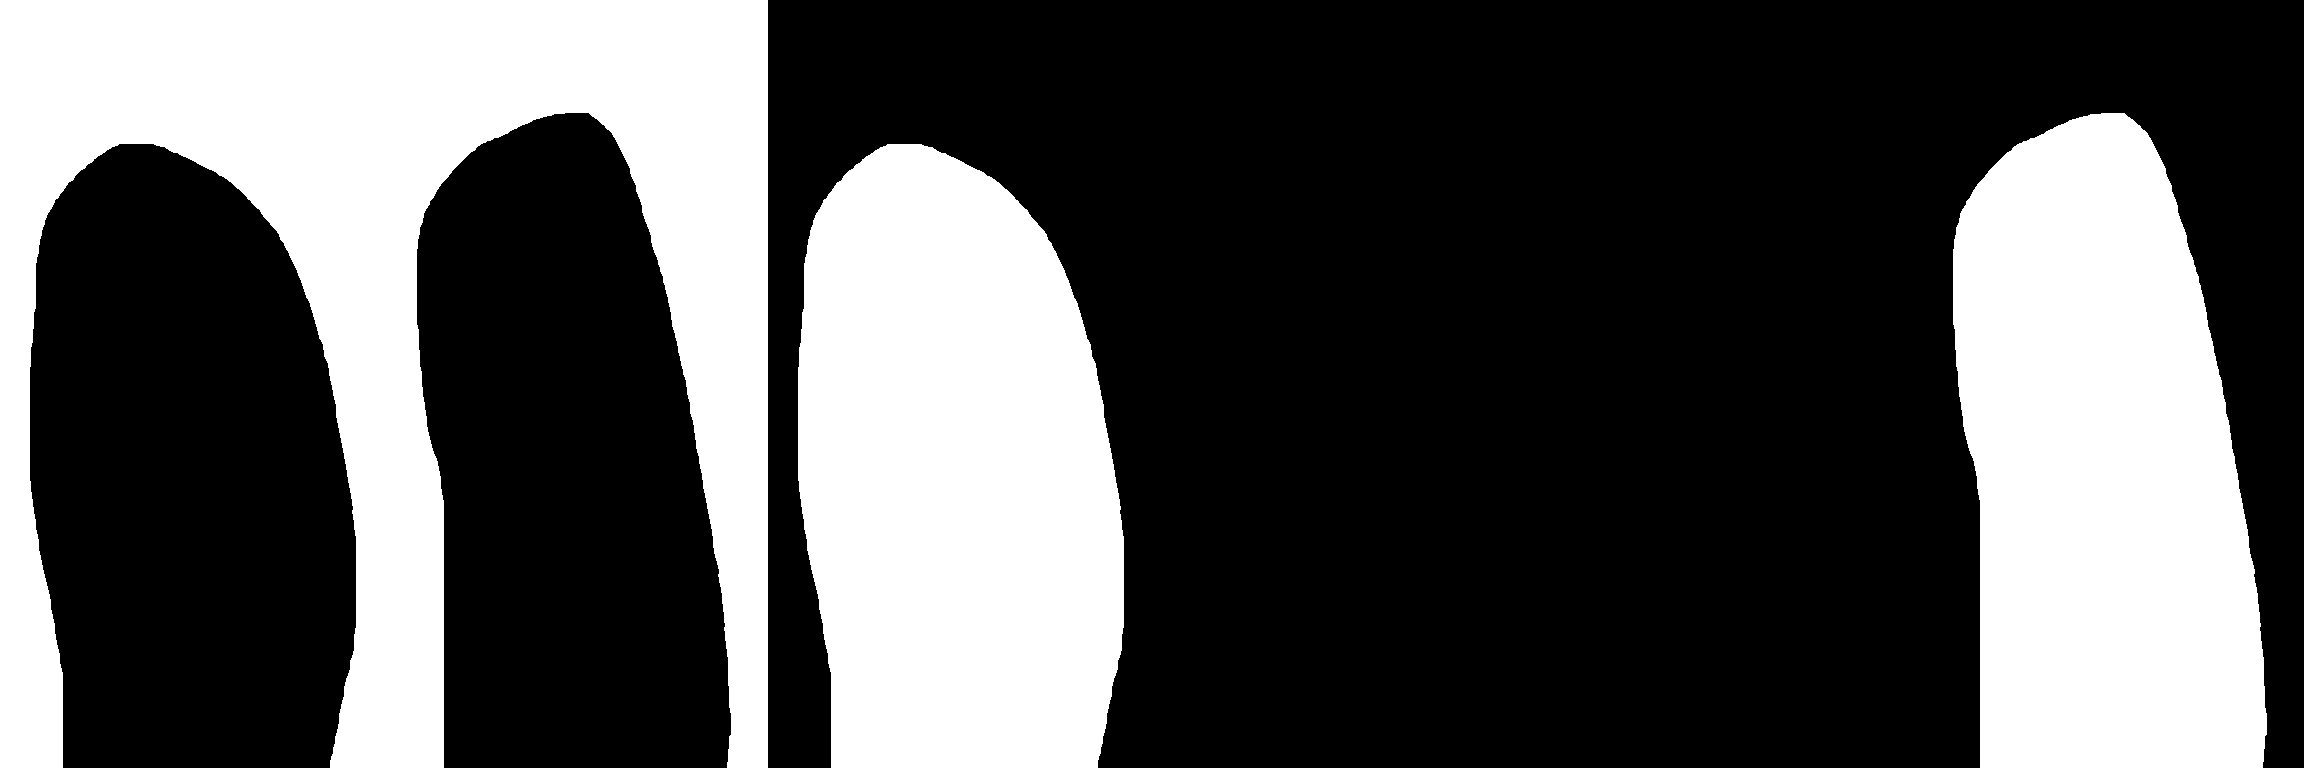

[INFO] Loading prompts...
Background Prompt: 1girl, 1boy, times square
Prompt1: 1boy, looking at viewer, brown hair, casual shirt
Prompt2: 1girl, looking at viewer, pink hair, leather jacket
Background Negative Prompt: worst quality, bad quality, normal quality, cropped, framed, 
Negative Prompt1: worst quality, bad quality, normal quality, cropped, framed, 1girl
Negative Prompt2: worst quality, bad quality, normal quality, cropped, framed, 1boy


In [4]:
# Prepare masks.
print('[INFO] Loading masks...')

name = 'timessquare'
mask_all = Image.open(f'../assets/{name}/{name}_full.png').convert('RGBA')
masks = [Image.open(f'../assets/{name}/{name}_{i}.png').convert('RGBA') for i in range(1, 3)]
masks = [(T.ToTensor()(mask)[-1:] > 0.5).float() for mask in masks]
# Background is simply non-marked set of pixels.
background = reduce(torch.logical_and, [m == 0 for m in masks])
dispt([background] + masks, row=1)

masks = torch.stack([background] + masks, dim=0)
mask_strengths = 1.0
mask_stds = 0.0

# Prepare prompts.
print('[INFO] Loading prompts...')

prompts = [
    # Background prompt.
    '1girl, 1boy, times square',
    # Foreground prompts.
    '1boy, looking at viewer, brown hair, casual shirt',
    '1girl, looking at viewer, pink hair, leather jacket',
]
negative_prompts = [
    '',
    '1girl',
    '1boy',
]
negative_prompt_prefix = 'worst quality, bad quality, normal quality, cropped, framed'
negative_prompts = [negative_prompt_prefix + ', ' + p for p in negative_prompts]

for i, prompt in enumerate(prompts):
    print((f'Prompt{i}' if i > 0 else 'Background Prompt') + ': ' + prompt)
for i, prompt in enumerate(negative_prompts):
    print((f'Negative Prompt{i}' if i > 0 else 'Background Negative Prompt') + ': ' + prompt)

height, width = masks.shape[-2:]

## Step 3: Generate images from multiple text prompts in 10 seconds!

100%|████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


Elapsed Time: 10.89714503288269


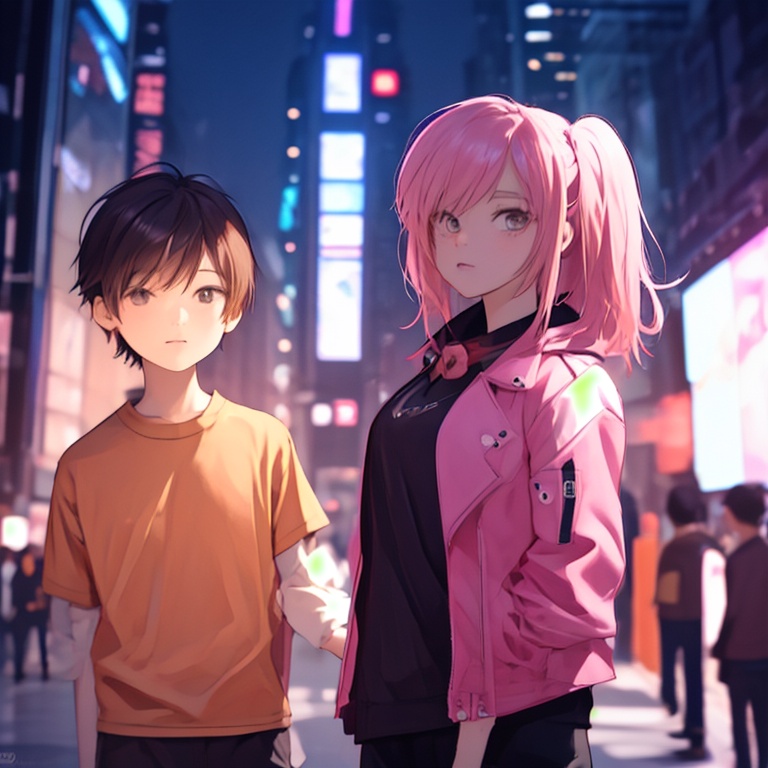

In [5]:
tic = time.time()
img = smd(
    prompts, negative_prompts, masks=masks.float(),
    mask_stds=mask_stds, mask_strengths=mask_strengths,
    height=height, width=width, bootstrap_steps=2,
)
toc = time.time()
print(f'Elapsed Time: {toc - tic}')
display(img)